In [1]:
## Imports

import json
import pickle
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
# Define data types for each column
dtypes = {
    "date": pl.Utf8,
    "cell_ll_lat": pl.Float32,
    "cell_ll_lon": pl.Float32,
    "mmsi": pl.Int32,
    "hours": pl.Float32,
    "fishing_hours": pl.Float32,
    "flag_registry": pl.Categorical,
    "flag_gfw": pl.Categorical,
    "vessel_class_inferred": pl.Categorical,
    "season": pl.Categorical
}

# Read CSV lazily using Polars
df_lazy = pl.scan_csv('MMSI-daily_merged_2019_2020-vessels-gfw-seasons.csv', schema_overrides=dtypes)

#Replace missing flag_registry entries with flag_gfw
df_lazy = df_lazy.with_columns(
    pl.coalesce([pl.col("flag_registry"), pl.col("flag_gfw")]).alias("flag_registry")
)

In [3]:
# Sample rows to reduce memory usage (here at 5%)
df_lazy = df_lazy.with_row_index("index")
row_count_df = df_lazy.select(pl.count("index").alias("row_count")).collect()
row_count = row_count_df["row_count"][0]
np.random.seed(20)
sample_n = int(0.05 * row_count) # Change this value to influence processing time
sample_indices = sorted(np.random.choice(row_count, size=sample_n, replace=False))
df_lazy = df_lazy.filter(pl.col("index").is_in(sample_indices)).drop("index")

In [4]:
# Collecting the lazy frames
df_polars = df_lazy.collect()

# Convert to pandas DataFrame
df = df_polars.to_pandas()

In [5]:
# Creating dummy variables for flag_registry so I get binary indicators for country flags
flag_dummies = pd.get_dummies(df['flag_registry'], prefix='flag')
df = pd.concat([df, flag_dummies], axis=1)

# Dummy variables for vessel class1
df = pd.get_dummies(df, columns=['vessel_class_registry'], drop_first=False)
# Saving the names for aggregation later
vessel_class_cols = [col for col in df.columns if col.startswith('vessel_class_registry_')]

#Here we are grouping coordinates and season, for each group we sum hours, fishing_hours, flag dummy values and vessel_class dummy values
#This allows us to predict vessel counts by flag for each cell in a season
agg_df = df.groupby(['cell_ll_lat', 'cell_ll_lon', 'season'],observed=True).agg({
    'hours': 'sum',
    'fishing_hours': 'sum',
    **{col: 'sum' for col in flag_dummies.columns},
    **{col: 'sum' for col in vessel_class_cols}
}).reset_index()

# Dummies for season, since we did this as a grouping key we generate the dummies after. While we generated the dummies for flag and vessels for summing aggregate counts.
agg_df = pd.get_dummies(agg_df, columns=['season'], drop_first=True)

# Define feature columns: location (lat &l lon), hours, fishing_hours, season dummies, and vessel class dummies.
features = ['cell_ll_lat', 'cell_ll_lon', 'hours', 'fishing_hours'] + \
           [col for col in df.columns if col.startswith('season_') or 
                                    col.startswith('vessel_class_registry_')]

# Target variable: Flag Counts for Given Cell and Time
targets = [col for col in agg_df.columns if col.startswith('flag_')]

# Define X and y
X = agg_df[features]
y = agg_df[targets]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Deleting unnecessary dataframes to free up memory
del agg_df, df, df_lazy, df_polars

In [6]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, lr_preds, squared=False)
print(f'Linear Regression RMSE: {lr_rmse}')

Linear Regression RMSE: 0.3438838614324129


In [7]:
# Random Forest Classifier

## n-estimators I just arbitrarily set at 5 for efficiency reasons, I attempted to test other levels but due to the size it was unfeasible to test multiple n-estimators
## Could increase n-estimators for possible improvement, would be interesting to test when we have more time
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=5, random_state=20, n_jobs=-1))
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False, multioutput='raw_values')
print(f'Random Forest RMSE per flag: {rf_rmse}')

Random Forest RMSE per flag: [6.26411404e-01 5.13097377e-01 6.24391865e+00 9.76020055e-01
 6.01373681e-01 1.14301688e-01 7.26010352e-02 7.27257391e-02
 1.11542636e-01 4.86184704e-01 4.95783319e-01 1.63675505e+00
 1.40088153e-01 8.16541181e-02 6.21611989e-02 7.85860392e-02
 1.13113112e-01 6.60274833e-02 3.67312597e-02 4.20687672e-01
 3.65875106e-02 2.47969810e-02 5.88952851e-02 2.04351617e-02
 4.09660503e-01 5.09288424e-02 7.87567676e-02 6.15012011e-02
 5.21803764e-02 1.34437073e-01 2.81585708e-02 1.25512349e-01
 2.98894636e-01 3.11348292e-02 3.62167711e-02 5.84131933e-02
 9.56762640e-02 5.51537224e-02 4.20269812e-02 2.98247185e-01
 2.99695121e-02 4.87878848e-02 3.24428247e-02 7.98185662e-02
 1.02894706e-01 3.69319165e-02 4.15489126e-01 4.13023268e-01
 1.08758502e-01 1.61378815e-01 2.72354878e-01 2.91501026e-01
 8.79589074e-02 5.70664451e-02 4.28122460e-01 5.77236202e-01
 2.14805007e-01 4.75153007e-01 2.58601211e-01 7.11697469e-02
 4.04196998e-02 5.29463389e-01 6.12593436e-02 2.44363733

In [8]:
#Extreme Gradient Boosting (XGBoost)
xgb_model = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=5, random_state=20, tree_method='hist',n_jobs=-1))
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False, multioutput='raw_values')
print(f'XGBoost RMSE per flag: {xgb_rmse}')

XGBoost RMSE per flag: [1.20040660e+00 8.87050515e-01 9.51485776e+00 1.37972930e+00
 9.48915025e-01 1.04872242e-01 7.13057825e-02 6.94227103e-02
 9.69401631e-02 7.09636059e-01 8.51890713e-01 1.84364179e+00
 1.42409338e-01 8.69159748e-02 5.93580737e-02 8.83981508e-02
 1.40927791e-01 6.66614400e-02 3.48038975e-02 7.54347032e-01
 3.60635325e-02 2.73518635e-02 5.98270705e-02 2.23354023e-02
 3.88650828e-01 5.38222112e-02 8.03269945e-02 5.76049557e-02
 4.68063808e-02 1.78638033e-01 2.78323887e-02 1.59968349e-01
 6.09923065e-01 2.66152774e-02 4.32367403e-02 6.72771119e-02
 1.20027481e-01 7.45913378e-02 5.79035973e-02 4.89259850e-01
 4.09713935e-02 5.25154920e-02 4.73279952e-02 1.04043874e-01
 2.36650144e-01 4.19299951e-02 9.35109121e-01 5.94911440e-01
 1.71944754e-01 2.67541425e-01 4.06181214e-01 3.77813995e-01
 1.09205786e-01 1.16855855e-01 5.04060403e-01 8.56488799e-01
 2.80330283e-01 8.15440334e-01 4.30272254e-01 9.27649293e-02
 3.58660775e-02 8.93312412e-01 8.88057522e-02 4.10150613e-01
 

Linear Regression RMSE: 0.3438838614324129
Random Forest RMSE per flag: 0.17633101880174498
Gradient Boosting RMSE per flag: 0.25311343414695603


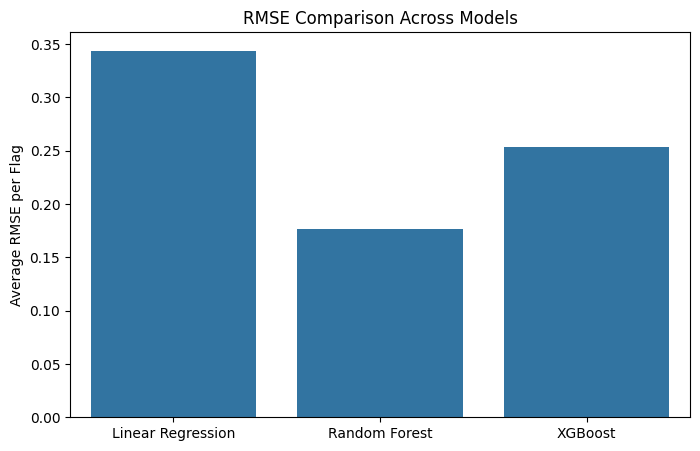

In [9]:
# Root Mean Squared Error (RMSE) Comparison

print(f'Linear Regression RMSE: {lr_rmse.mean()}')

print(f'Random Forest RMSE per flag: {rf_rmse.mean()}')

print(f'Gradient Boosting RMSE per flag: {xgb_rmse.mean()}')

rmse_scores = {"Linear Regression":lr_rmse,"Random Forest": rf_rmse.mean(), "XGBoost": xgb_rmse.mean()}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(rmse_scores.keys()), y=list(rmse_scores.values()))
plt.ylabel("Average RMSE per Flag")
plt.title("RMSE Comparison Across Models")
plt.show()

Linear Regression MAE: 0.050666563519955646
Random Forest MAE per flag: 0.01048472540984883
Gradient Boosting MAE per flag: 0.024689518804498763


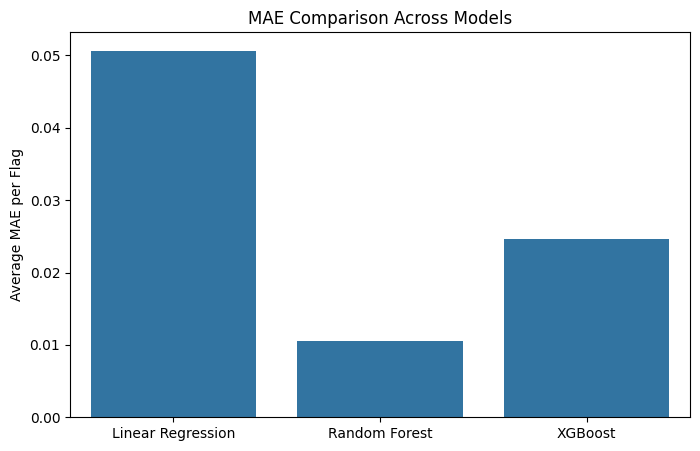

In [10]:
# Mean Absolute Error (MAE) Comparison

lr_mae = mean_absolute_error(y_test, lr_preds)
print(f'Linear Regression MAE: {lr_mae}')

rf_mae = mean_absolute_error(y_test, rf_preds)
print(f'Random Forest MAE per flag: {rf_mae}')

xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f'Gradient Boosting MAE per flag: {xgb_mae}')

mae_scores = {"Linear Regression": lr_mae, "Random Forest": rf_mae.mean(), "XGBoost": xgb_mae.mean()}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()))
plt.ylabel("Average MAE per Flag")
plt.title("MAE Comparison Across Models")
plt.show()

## Using MAE we also see a similar result.

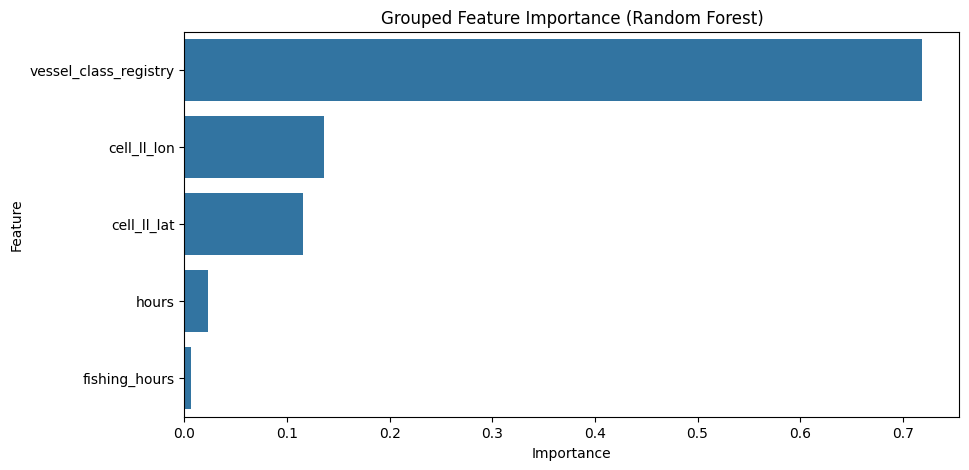

In [11]:
# Feature Importance for Random Forest Model

fi = pd.Series(rf_model.estimators_[0].feature_importances_, index=features)
vessel_class_mask = fi.index.str.startswith('vessel_class_registry_')
vessel_class_importance = fi[vessel_class_mask].sum()
fi_grouped = fi[~vessel_class_mask].copy()
fi_grouped['vessel_class_registry'] = vessel_class_importance

fi_grouped = fi_grouped.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=fi_grouped, y=fi_grouped.index)
plt.title("Grouped Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Vessel_class seems to be very important for determining flagging, while the hours out at sea/fishing seem to be very unimportant. 

In [12]:
# Context for RMSE/MAE

print("Overall Mean of Flag Counts",y.to_numpy().flatten().mean())
print("Overall Standard Deviation of Flag Counts",y.to_numpy().flatten().std())
print("One Standard Deviation away from the mean is between", y.to_numpy().flatten().mean()-y.to_numpy().flatten().std(),"and",y.to_numpy().flatten().mean()+y.to_numpy().flatten().std())
## This shows our models are fairly good predictors as the RMSE is within a standard deviation

Overall Mean of Flag Counts 0.02431025781540142
Overall Standard Deviation of Flag Counts 1.5317594517499347
One Standard Deviation away from the mean is between -1.5074491939345331 and 1.5560697095653362


In [13]:
# R-Squared Reporting

overall_r2_lr = r2_score(y_test, lr_preds)
overall_r2_rf = r2_score(y_test, rf_preds)
overall_r2_xgb = r2_score(y_test, xgb_preds)

print("Overall R^2 (Linear Regression):", overall_r2_lr)
print("Overall R^2 (Random Forest):", overall_r2_rf)
print("Overall R^2 (XG Gradient Boosting):", overall_r2_xgb)

## Looks like Random Forest is capturing the most variation in our data. At .41 there is still room for improvement, there are likely still many variables we could use to improve predictive power (even in this dataset) but this shows that clearly random forest is performing the best out of these three right now

Overall R^2 (Linear Regression): 0.07973059114193981
Overall R^2 (Random Forest): 0.435166859255595
Overall R^2 (XG Gradient Boosting): 0.4029254027324885


In [14]:
# Cross-Valdiation

flag0 = y_test.columns[0]
rf = RandomForestRegressor(n_estimators=5, random_state=20, n_jobs=-1)

scores = cross_val_score(rf, X_train, y_train[flag0], cv=5, scoring='neg_mean_squared_error')
rmse_scores_cv = np.sqrt(-scores)
print(f"Cross-validated RMSE for {flag0}: {rmse_scores_cv}")

## Cross-validation step, looks like overall there's only a little variation with RMSE between folds, although its not zero. Overall the model is performing fairly consistently. Note Flag ESP RMSE is ~0.62, this is fairly consistent

Cross-validated RMSE for flag_ESP: [0.64418    0.59761099 0.55644662 0.5808399  0.67859196]


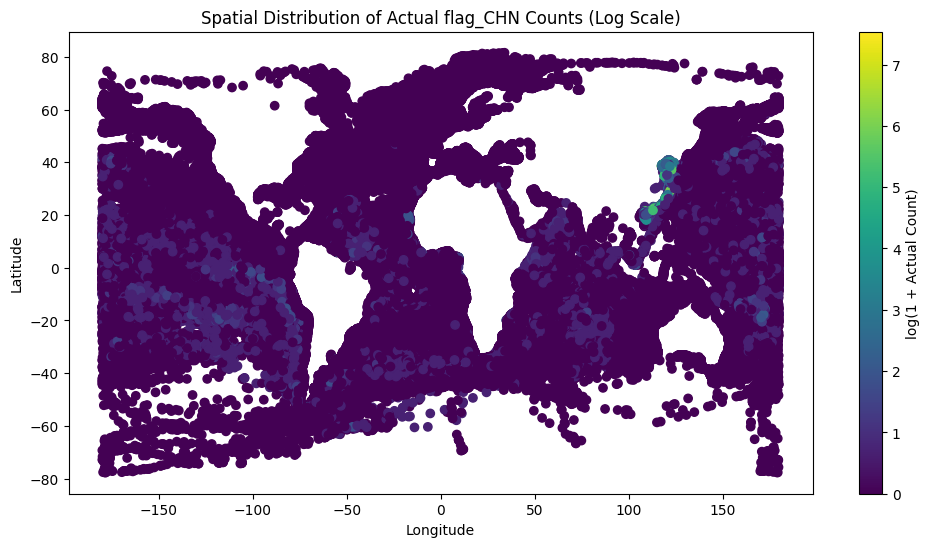

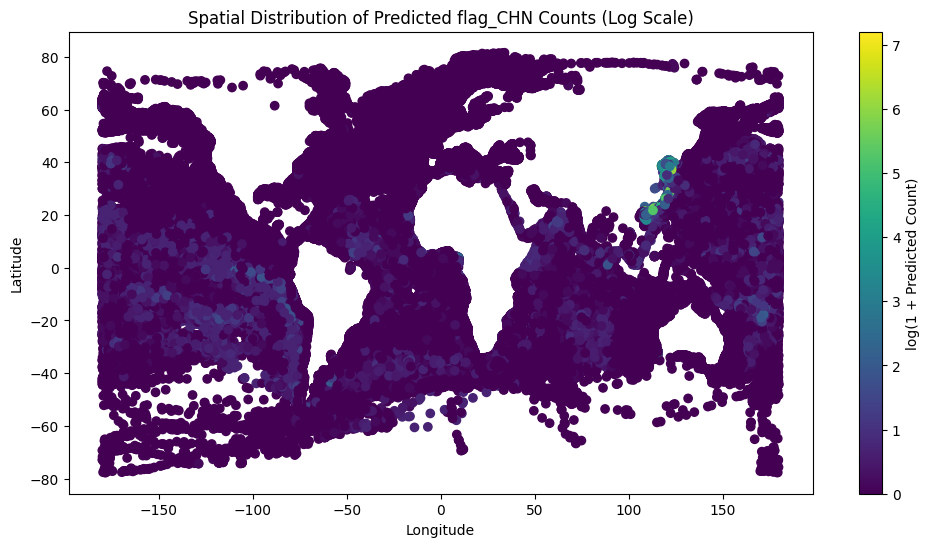

In [15]:
# Spatial Maps for Testing/Robustness

##Chinese Flagged Vessels (log scale) vs Our predicted flagged vessels (log scale)

flag = 'flag_CHN'

plt.figure(figsize=(12, 6))
plt.scatter(X_test['cell_ll_lon'], X_test['cell_ll_lat'], c=np.log1p(y_test[flag]), cmap='viridis')
plt.colorbar(label='log(1 + Actual Count)')
plt.title(f"Spatial Distribution of Actual {flag} Counts (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(X_test['cell_ll_lon'], X_test['cell_ll_lat'], c=np.log1p(rf_preds[:, list(y_test.columns).index(flag)]), cmap='viridis', label='Predicted')
plt.colorbar(label='log(1 + Predicted Count)')
plt.title(f"Spatial Distribution of Predicted {flag} Counts (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### It's difficult to visually determine this much data, but just a brief glance looks like our model is doing pretty well for Chinese flagged vessels at the very least. By eye these maps looks identical.

In [16]:
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("Models saved as 'lr_model.pkl', 'rf_model.pkl', and 'xgb_model.pkl'.")

Models saved as 'lr_model.pkl', 'rf_model.pkl', and 'xgb_model.pkl'.
